# Set up

In [1]:
# install.packages("vars")
library("vars")
library("tidyverse")

Loading required package: MASS

Loading required package: strucchange

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: urca

Loading required package: lmtest



In [2]:
data(Canada)
summary(Canada)

       e              prod             rw              U         
 Min.   :928.6   Min.   :401.3   Min.   :386.1   Min.   : 6.700  
 1st Qu.:935.4   1st Qu.:404.8   1st Qu.:423.9   1st Qu.: 7.782  
 Median :946.0   Median :406.5   Median :444.4   Median : 9.450  
 Mean   :944.3   Mean   :407.8   Mean   :440.8   Mean   : 9.321  
 3rd Qu.:950.0   3rd Qu.:410.7   3rd Qu.:461.1   3rd Qu.:10.607  
 Max.   :961.8   Max.   :418.0   Max.   :470.0   Max.   :12.770  

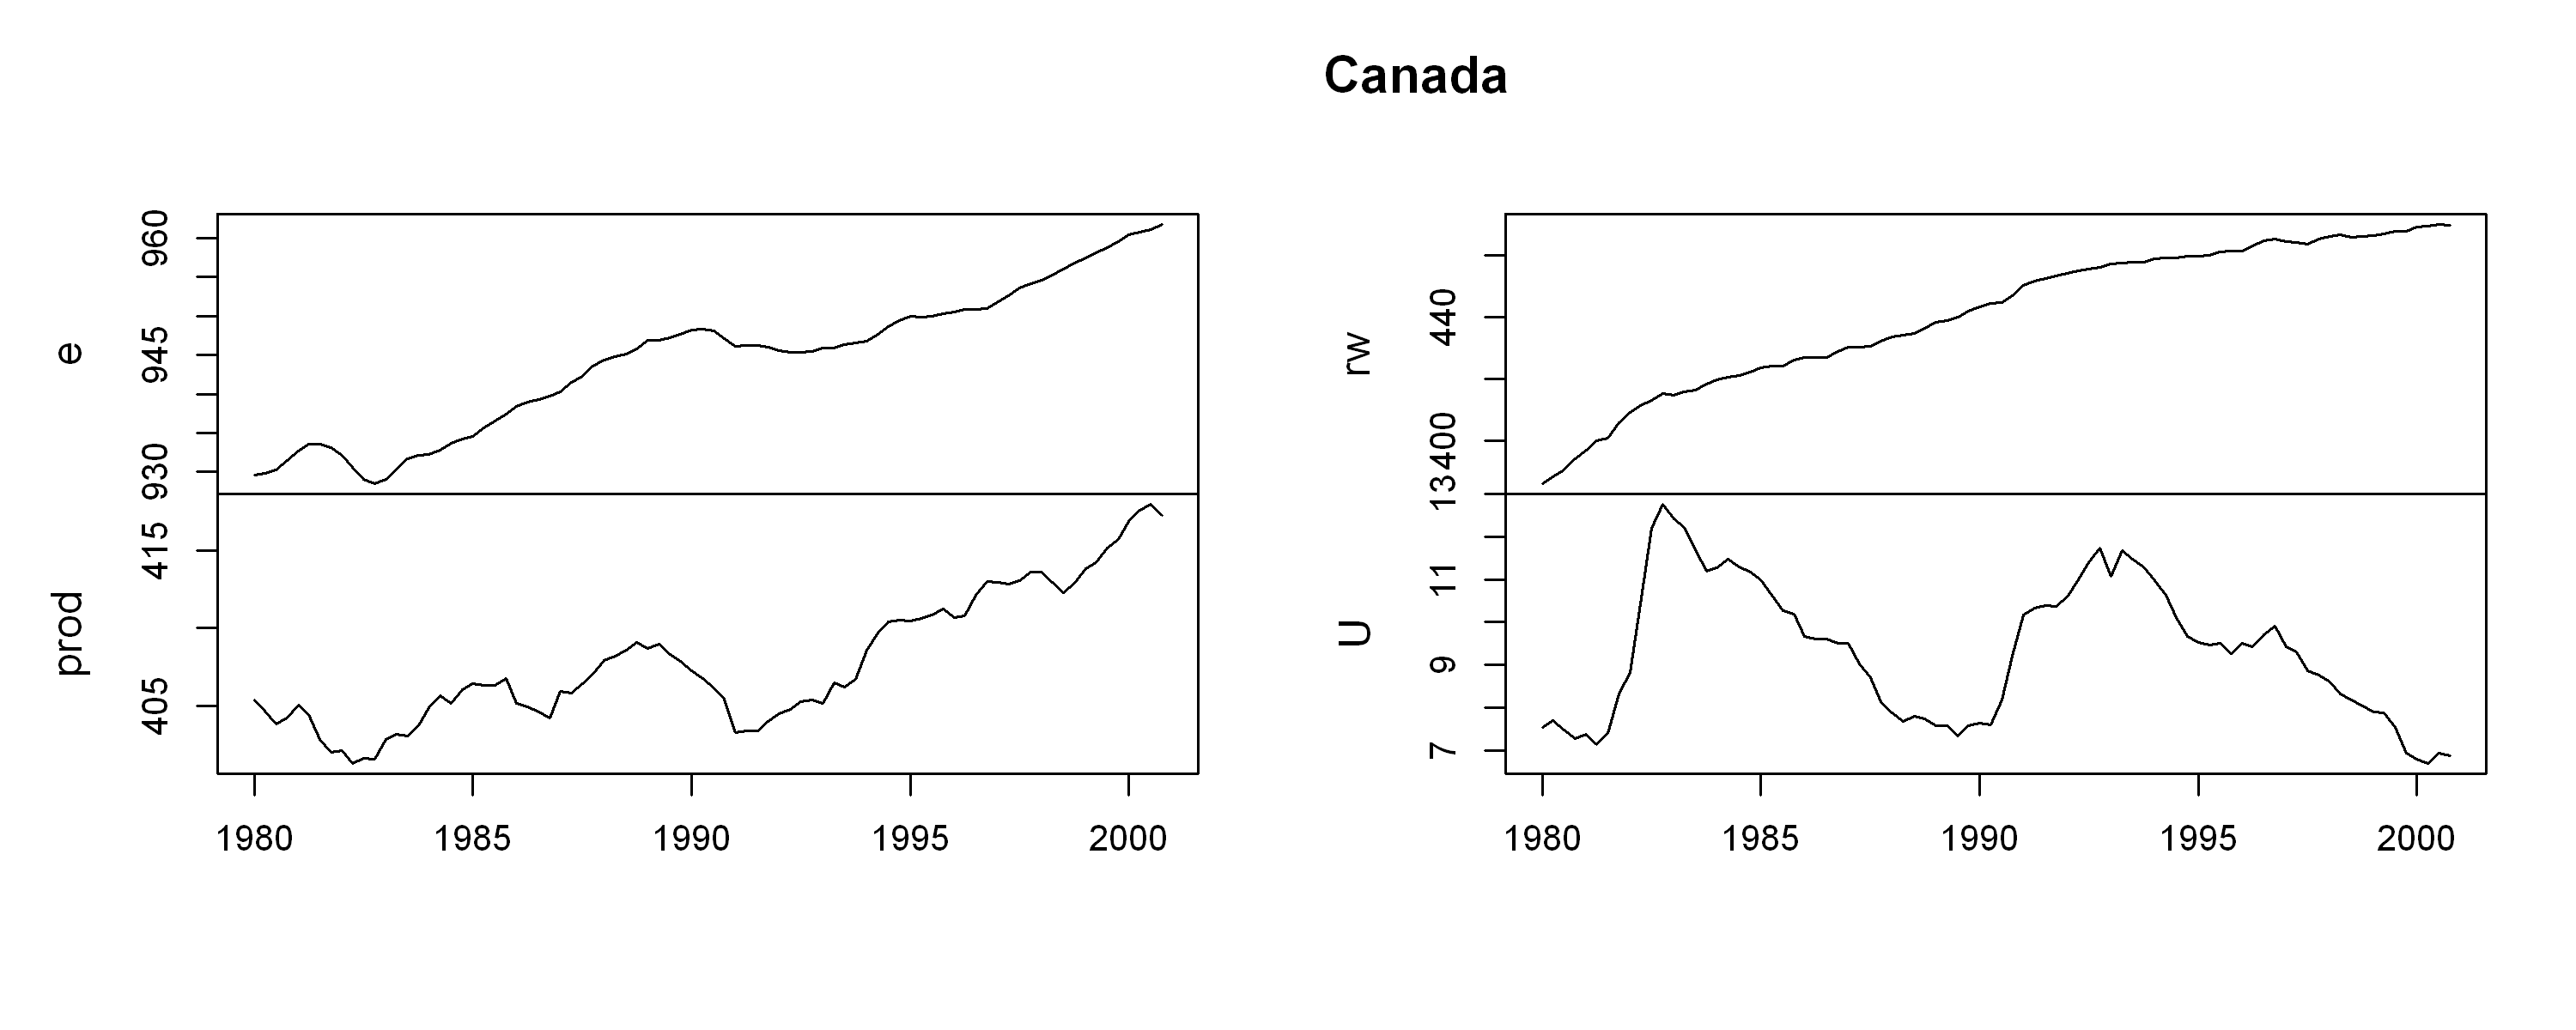

In [3]:
plot(Canada, nc = 2, xlab = "")

In [27]:
ur.df(Canada[,c("prod")], type = "drift", selectlags = "AIC")


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -0.1144 0.9485 


In [26]:
ur.df(Canada[,c("prod")], type = "trend", selectlags = "AIC")


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -2.0216 2.4483 2.6786 


In [30]:
ur.df(Canada[, 'prod'], type = "none", selectlags = "AIC")


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: 1.3799 


In [33]:
summary(ur.df(Canada[,c("prod")], type="drift", selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.05018 -0.40444  0.08499  0.42631  1.74816 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  1.025983   8.023600   0.128  0.89858   
z.lag.1     -0.002252   0.019690  -0.114  0.90922   
z.diff.lag   0.300758   0.112574   2.672  0.00916 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6981 on 79 degrees of freedom
Multiple R-squared:  0.08828,	Adjusted R-squared:  0.06519 
F-statistic: 3.824 on 2 and 79 DF,  p-value: 0.02598


Value of test-statistic is: -0.1144 0.9485 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.51 -2.89 -2.58
phi1  6.70  4.71  3.86


In [63]:
str(dimnames(testres %>% slot("cval"))[1])

List of 1
 $ : chr [1:3] "tau3" "phi2" "phi3"


In [69]:
lapply(dimnames(testres %>% slot("cval"))[1], paste0, "x")

[[1]]
[1] "tau3x" "phi2x" "phi3x"

In [114]:
df = as.data.frame(Canada)

In [164]:
xx = list(drift = "mu", trend = "tau")
xx$"drift"

[1] "mu"

In [166]:
xx[[1]]

[1] "mu"

In [5]:
data = as.data.frame(Canada)

In [43]:
x = (ur.df(data[, 'prod'], type="drift") %>% slot("teststat"))[, 'tau2']
x = (ur.kpss(ser, type = kpss_map[[type]], lags = "long"))

[1] -0.1143872

In [350]:
adf = ur.df(data[, 'prod'], type = "trend", selectlags = "AIC")
kpss = ur.kpss(data[, 'prod'], type = "tau", lags = "short")

In [352]:
kpss %>% slot("cval")

,10pct,5pct,2.5pct,1pct
critical values,0.119,0.146,0.176,0.216


In [353]:
adf_report = function(obj) {
  lag = (obj %>% slot("lags"))
  tstat = (t(obj %>% slot("teststat"))) %>% as.data.frame()
  colnames(tstat) = "tstat"
  cval = (obj %>% slot("cval")) %>% as.data.frame()
  colnames(cval) = c('cv01', 'cv05', 'cv10')
  res = data.frame(lag, tstat, cval)
  res['test'] = "ADF"
  res = res[1,]
  rownames(res) = NULL
  return(res)
}

kpss_report = function(obj) {
  lag = (obj %>% slot("lag"))
  tstat = obj %>% slot("teststat")
  cval = (obj %>% slot("cval")) %>% as.data.frame() %>% select(-3)
  colnames(cval) = c('cv10', 'cv05', 'cv01')
  res = data.frame(lag, tstat, cval)
  res['test'] = "KPSS"
  rownames(res) = NULL
  return(res)
}

In [354]:
adf_report(adf)

lag,tstat,cv01,cv05,cv10,test
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-2.021648,-4.04,-3.45,-3.15,ADF


In [355]:
kpss_report(kpss)

lag,tstat,cv10,cv05,cv01,test
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3,0.2668509,0.119,0.146,0.216,KPSS


In [360]:
unit_test = function(data, type=c("drift", "trend"), difference=FALSE) {
  kpss_map = list(drift = "mu", trend = "tau")
  col_names = colnames(data)
  res_1 = data.frame()
  res_2 = data.frame()
  
  for( i in seq_along(col_names) ) {
    ser = data[[col_names[i]]]
    ser = if (difference) diff(ser) else ser 
    level = if (difference) "d1" else "d0"
      
    adf = ur.df(ser, type = type, selectlags = "BIC")
    test_res = adf_report(adf)
    test_res['col_name']  = col_names[i]
    res_1 = rbind(res_1, test_res)
    
    kpss = ur.kpss(ser, type = kpss_map[[type]], lags = "short")
    test_res = kpss_report(kpss)
    test_res['col_name']  = col_names[i]
    res_2 = rbind(res_2, test_res)
    
    res = bind_rows(res_1, res_2)
    res['level'] = level
    res['type'] = type
  }
  return(res)
} 

In [361]:
unit_test(data, type = "trend", difference = FALSE)

lag,tstat,cv01,cv05,cv10,test,col_name,level,type
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-2.7285715,-4.040,-3.450,-3.150,ADF,e,d0,trend
1,-2.0216481,-4.040,-3.450,-3.150,ADF,prod,d0,trend
1,-2.8162969,-4.040,-3.450,-3.150,ADF,rw,d0,trend
1,-2.4652407,-4.040,-3.450,-3.150,ADF,U,d0,trend
3,0.1684487,0.216,0.146,0.119,KPSS,e,d0,trend
3,0.2668509,0.216,0.146,0.119,KPSS,prod,d0,trend
3,0.4270528,0.216,0.146,0.119,KPSS,rw,d0,trend
3,0.1417123,0.216,0.146,0.119,KPSS,U,d0,trend


In [362]:
unit_test_report = function(data) {
  res1 = unit_test(data, type = "drift", difference = FALSE)
  res2 = unit_test(data, type = "trend", difference = FALSE)
  res3 = unit_test(data, type = "drift", difference = TRUE)
  res = bind_rows(res1, res2, res3)
  result = res %>%
    gather("key", "value", -col_name, -test, -level, -type) %>%
    mutate(key = paste(test, key, sep = "_")) %>%
    select(-test) %>%
    spread(key, value) %>%
    mutate(stationary_ADF  = ADF_tstat < ADF_cv05) %>%
    mutate(stationary_KPSS = KPSS_tstat < KPSS_cv05)  
  
  return(result)
}

In [363]:
unit_test_report(data)

col_name,level,type,ADF_cv01,ADF_cv05,ADF_cv10,ADF_lag,ADF_tstat,KPSS_cv01,KPSS_cv05,KPSS_cv10,KPSS_lag,KPSS_tstat,stationary_ADF,stationary_KPSS
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
e,d0,drift,-3.51,-2.89,-2.58,1,-0.2996982,0.739,0.463,0.347,3,2.0460502,FALSE,FALSE
e,d0,trend,-4.04,-3.45,-3.15,1,-2.7285715,0.216,0.146,0.119,3,0.1684487,FALSE,FALSE
e,d1,drift,-3.51,-2.89,-2.58,1,-4.5107079,0.739,0.463,0.347,3,0.1119918,TRUE,TRUE
prod,d0,drift,-3.51,-2.89,-2.58,1,-0.1143872,0.739,0.463,0.347,3,1.6574218,FALSE,FALSE
prod,d0,trend,-4.04,-3.45,-3.15,1,-2.0216481,0.216,0.146,0.119,3,0.2668509,FALSE,FALSE
prod,d1,drift,-3.51,-2.89,-2.58,1,-5.1604251,0.739,0.463,0.347,3,0.2457936,TRUE,TRUE
rw,d0,drift,-3.51,-2.89,-2.58,1,-4.3667423,0.739,0.463,0.347,3,2.1237643,TRUE,FALSE
rw,d0,trend,-4.04,-3.45,-3.15,1,-2.8162969,0.216,0.146,0.119,3,0.4270528,FALSE,FALSE
rw,d1,drift,-3.51,-2.89,-2.58,1,-4.2402356,0.739,0.463,0.347,3,1.1013768,TRUE,FALSE


In [23]:
library("openxlsx")

In [24]:
write.xlsx(result, "result.xlsx")

In [297]:
unit_test(data, type="drift") %>%
  gather("key", "value", -col_name, -test_name) %>%
  mutate(key = paste(test_name, key, sep = "_")) %>%
  select(-test_name) %>%
  spread(key, value)

col_name,ADF_10pct,ADF_1pct,ADF_2.5pct,ADF_5pct,ADF_teststat,KPSS_10pct,KPSS_1pct,KPSS_2.5pct,KPSS_5pct,KPSS_teststat
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
e,-2.58,-3.51,NA,-2.89,-4.510708,0.347,0.739,0.574,0.463,0.1119918
prod,-2.58,-3.51,NA,-2.89,-5.160425,0.347,0.739,0.574,0.463,0.2457936
rw,-2.58,-3.51,NA,-2.89,-4.240236,0.347,0.739,0.574,0.463,1.1013768
U,-2.58,-3.51,NA,-2.89,-3.926263,0.347,0.739,0.574,0.463,0.1988622


In [112]:
df = data.frame()
df["x"] = "2"

ERROR: Error in `[<-.data.frame`(`*tmp*`, "x", value = "2"): replacement has 1 row, data has 0


In [81]:
as.data.frame(ur.kpss(Canada[,c("prod")], type = "tau", lags = "short") %>% slot("cval"))

,10pct,5pct,2.5pct,1pct
,<dbl>,<dbl>,<dbl>,<dbl>
critical values,0.119,0.146,0.176,0.216


In [192]:
as.data.frame(ur.df(Canada[,c("prod")], type = "trend", selectlags = "AIC") %>% slot("teststat"))

,tau3,phi2,phi3
,<dbl>,<dbl>,<dbl>
statistic,-2.021648,2.44827,2.678632


In [25]:
library(xtable)

In [31]:
help(ca.jo)

ca.jo {urca},R Documentation
x,Data matrix to be investigated for cointegration.
type,"The test to be conducted, either ‘eigen’ or ‘trace’."
ecdet,"Character, ‘none’ for no intercept in cointegration, ‘const’ for constant term in cointegration and ‘trend’ for trend variable in cointegration."
K,The lag order of the series (levels) in the VAR.
spec,"Determines the specification of the VECM, see details below."
season,"If seasonal dummies should be included, the data frequency must be set accordingly, i.e ‘4’ for quarterly data."
dumvar,"If dummy variables should be included, a matrix with row dimension equal to x can be provided."


In [19]:
VARselect(Canada, lag.max=8, type="both")

,1,2,3,4,5,6,7,8
AIC(n),-6.272579064,-6.636669705,-6.771176872,-6.634609210,-6.398132246,-6.307704843,-6.070727259,-6.06159685
HQ(n),-5.978429449,-6.146420347,-6.084827770,-5.752160366,-5.319583658,-5.033056512,-4.599979185,-4.39474903
SC(n),-5.536558009,-5.409967947,-5.053794411,-4.426546046,-3.699388378,-3.118280272,-2.390621985,-1.89081087
FPE(n),0.001889842,0.001319462,0.001166019,0.001363175,0.001782055,0.002044202,0.002768551,0.00306012


In [33]:
summary(ca.jo(Canada, type="eigen", ecdet=, K=3, spec="longrun"))


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 0.4178095905 0.1828654499 0.1239725051 0.0007523871

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 3 |  0.06  6.50  8.18 11.65
r <= 2 | 10.72 12.91 14.90 19.19
r <= 1 | 16.36 18.90 21.07 25.75
r = 0  | 43.82 24.78 27.14 32.14

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              e.l3    prod.l3      rw.l3       U.l3
e.l3     1.0000000  1.0000000  1.0000000  1.0000000
prod.l3  0.6409112  0.2993240 -0.5765703 -0.1674879
rw.l3   -0.6996053 -0.3775646 -0.3098725 -0.3210560
U.l3     0.5506937  2.7029914  1.7800952  1.5046076

Weights W:
(This is the loading matrix)

              e.l3    prod.l3       rw.l3         U.l3
e.d    0.025577740  0.1542901 -0.01923271 -0.004492451
prod.d 0.001322905  0.1470512  0.08043698  0.015693650
rw

In [24]:
summary(ca.jo(Canada, type="eigen", ecdet=, K=3, spec="transitory"))


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 0.4178095905 0.1828654499 0.1239725052 0.0007523871

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 3 |  0.06  6.50  8.18 11.65
r <= 2 | 10.72 12.91 14.90 19.19
r <= 1 | 16.36 18.90 21.07 25.75
r = 0  | 43.82 24.78 27.14 32.14

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              e.l1    prod.l1      rw.l1       U.l1
e.l1     1.0000000  1.0000000  1.0000000  1.0000000
prod.l1  0.6409112  0.2993240 -0.5765703 -0.1674879
rw.l1   -0.6996053 -0.3775646 -0.3098725 -0.3210560
U.l1     0.5506937  2.7029914  1.7800952  1.5046076

Weights W:
(This is the loading matrix)

              e.l1    prod.l1       rw.l1         U.l1
e.d    0.025577740  0.1542901 -0.01923271 -0.004492451
prod.d 0.001322905  0.1470512  0.08043698  0.015693650
rw

In [ ]:
ca.jo(x, type = c("eigen", "trace"), ecdet = c("none", "const", "trend"), K = 2,
spec=c("longrun", "transitory"), season = NULL, dumvar = NULL)

In [36]:
x <- ca.jo(Canada, type="eigen", ecdet=, K=3, spec="transitory")

In [58]:
# library(AER)
# library(dynlm)
# library(forecast)
# library(readxl)
# library(stargazer)
# library(scales)
# library(quantmod)
# library(urca)